## Summary

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

## Import Datasets

In [2]:
enron_df = pd.read_csv('datasets/explored/enron-emails-explored.csv')
mal_df = pd.read_csv('datasets/explored/malicious-emails-explored.csv')

Create the Training sets

In [3]:
import random


part_1 = enron_df.sample(11871, ignore_index=True, random_state=1)
part_2 = mal_df
rand = round(random.random())

training_set = (pd.concat([part_1, part_2], ignore_index=True)).sample(frac=1, ignore_index=True, random_state=rand)

In [4]:
training_set.columns

Index(['raw_mail', 'subject', 'from', 'to', 'status', 'date', 'body',
       'parsed_from', 'parsed_to', 'parsed_date', 'malicious', 'content_type',
       'charset', 'content_transfer_encoding', 'from_domain', 'to_domain',
       'html', 'javascript', 'css', 'html_form', 'html_iframe',
       'URLs_in_message', 'subject_len', 'subject_entropy', 'body_entropy',
       'attachement'],
      dtype='object')

In [5]:
features = ['html', 
            'javascript', 
            'css', 
            'html_form', 
            'html_iframe',
            'URLs_in_message', 
            'subject_len', 
            'subject_entropy', 
            'body_entropy',
            'attachement']

In [6]:
X = training_set[features]
y = training_set.malicious

train_X, val_X, train_y, val_y = train_test_split(X, y,random_state = rand)

In [7]:
X.describe()

,URLs_in_message,subject_len,subject_entropy,body_entropy
count,20000.000000,20000.000000,20000.000000,20000.000000
mean,2.676050,30.771800,3.696848,4.793095
std,8.816654,31.105961,0.631801,0.486961
min,0.000000,1.000000,-0.000000,-0.000000
25%,0.000000,17.000000,3.452820,4.552525
50%,0.000000,26.000000,3.794653,4.806861
75%,1.000000,40.000000,4.092136,5.056293
max,142.000000,2659.000000,5.359526,6.134659


In [52]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sn
import matplotlib.pyplot as plt


## Decision Tree

Number of mislabeled points out of a total: 5000 points: 830
The accuracy of the model is: 83%
Precision of the model is: 80%
Recall of the model is: 81%
F1 score of the model is: 80


<AxesSubplot:>

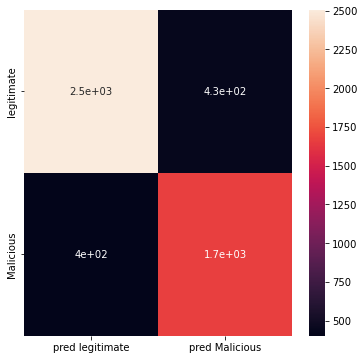

In [54]:
dts_clf = DecisionTreeClassifier(random_state=rand)
dts_model = dts_clf.fit(train_X, train_y)
pred_y = dts_model.predict(val_X)

print(f"Number of mislabeled points out of a total: {len(val_X)} points: {(val_y != pred_y).sum()}")
print(f"The accuracy of the model is: {round((val_y == pred_y).sum() / len(val_X) * 100)}%")
print(f'Precision of the model is: {round(precision_score(val_y, pred_y) * 100)}%')
print(f'Recall of the model is: {round(recall_score(val_y, pred_y) * 100)}%')
print(f'F1 score of the model is: {round(f1_score(val_y, pred_y) * 100)}%')

cm = confusion_matrix(val_y, pred_y)
df_cm = pd.DataFrame(cm, index=['legitimate', 'Malicious'], columns=['pred legitimate', 'pred Malicious'])

plt.figure(figsize=(6,6))
sn.heatmap(df_cm, annot=True)

## KNN

Number of mislabeled points out of a total: 5000 points: 914
The accuracy of the model is: 82%
Precision of the model is: 79%
Recall of the model is: 76%


<AxesSubplot:>

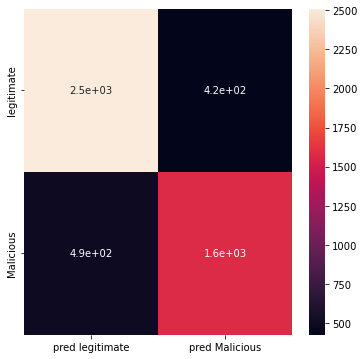

In [49]:
knn_clf = KNeighborsClassifier()
knn_model = knn_clf.fit(train_X, train_y)
pred_y = knn_model.predict(val_X)

print(f"Number of mislabeled points out of a total: {len(val_X)} points: {(val_y != pred_y).sum()}")
print(f"The accuracy of the model is: {round((val_y == pred_y).sum() / len(val_X) * 100)}%")
print(f'Precision of the model is: {round(precision_score(val_y, pred_y) * 100)}%')
print(f'Recall of the model is: {round(recall_score(val_y, pred_y) * 100)}%')
print(f'F1 score of the model is: {round(f1_score(val_y, pred_y) * 100)}%')

cm = confusion_matrix(val_y, pred_y)
df_cm = pd.DataFrame(cm, index=['legitimate', 'Malicious'], columns=['pred legitimate', 'pred Malicious'])

plt.figure(figsize=(6,6))
sn.heatmap(df_cm, annot=True)

## Random Forest

Number of mislabeled points out of a total: 5000 points: 667
The accuracy of the model is: 87%
Precision of the model is: 85%
Recall of the model is: 82%


<AxesSubplot:>

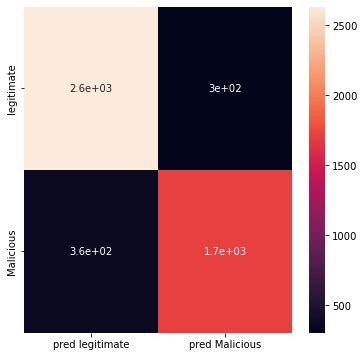

In [50]:
rf_clf = RandomForestClassifier(random_state=rand)
rf_model = rf_clf.fit(train_X, train_y)
pred_y = rf_model.predict(val_X)

print(f"Number of mislabeled points out of a total: {len(val_X)} points: {(val_y != pred_y).sum()}")
print(f"The accuracy of the model is: {round((val_y == pred_y).sum() / len(val_X) * 100)}%")
print(f'Precision of the model is: {round(precision_score(val_y, pred_y) * 100)}%')
print(f'Recall of the model is: {round(recall_score(val_y, pred_y) * 100)}%')
print(f'F1 score of the model is: {round(f1_score(val_y, pred_y) * 100)}%')

cm = confusion_matrix(val_y, pred_y)
df_cm = pd.DataFrame(cm, index=['legitimate', 'Malicious'], columns=['pred legitimate', 'pred Malicious'])

plt.figure(figsize=(6,6))
sn.heatmap(df_cm, annot=True)

## Naive Bayes

Number of mislabeled points out of a total: 5000 points: 1352
The accuracy of the model is: 73%
Precision of the model is: 97%
Recall of the model is: 36%


<AxesSubplot:>

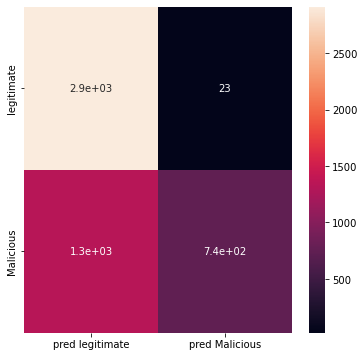

In [51]:
nb_clf = GaussianNB()
nb_model = nb_clf.fit(train_X, train_y)
pred_y = nb_model.predict(val_X)

print(f"Number of mislabeled points out of a total: {len(val_X)} points: {(val_y != pred_y).sum()}")
print(f"The accuracy of the model is: {round((val_y == pred_y).sum() / len(val_X) * 100)}%")
print(f'Precision of the model is: {round(precision_score(val_y, pred_y) * 100)}%')
print(f'Recall of the model is: {round(recall_score(val_y, pred_y) * 100)}%')
print(f'F1 score of the model is: {round(f1_score(val_y, pred_y) * 100)}%')

cm = confusion_matrix(val_y, pred_y)
df_cm = pd.DataFrame(cm, index=['legitimate', 'Malicious'], columns=['pred legitimate', 'pred Malicious'])

plt.figure(figsize=(6,6))
sn.heatmap(df_cm, annot=True)